<a href="https://colab.research.google.com/github/cuomo2236364-create/FDS-20252026/blob/main/VIT_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Loading all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.image as mpimg
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms, datasets
import torch
import random
from PIL import Image
from torchvision.transforms import functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.amp import autocast, GradScaler
from torch.utils.data import Subset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import copy





In [41]:
# Cloning the GitHub repos of the metadata

!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2025-12-23 17:41:38--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81M   142MB/s    in 2.4s    

2025-12-23 17:41:41 (142 MB/s) - ‘fma_metadata.zip’ saved [358412441/358412441]



In [42]:
# Unzipping the  folder previously loaded

for zip_path in ["fma_metadata.zip"]:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall()

In [43]:
# Generating  tables (from the metadata) with information regarding the 8.000 audio tracks

tracks = pd.read_csv('fma_metadata/tracks.csv', index_col = 0, header = [0, 1])
genres = pd.read_csv('fma_metadata/genres.csv', index_col = 0)

print("Tracks:", tracks.shape)
print("Genres:", genres.shape)


Tracks: (106574, 52)
Genres: (163, 4)


In [44]:
#spectrogram extraction
OUTPUT_DIR = "fma_spectrograms_clean"
os.makedirs(OUTPUT_DIR, exist_ok=True)

with zipfile.ZipFile("fma_spectrograms.zip", "r") as zip_ref:
    for member in zip_ref.namelist():
        filename = os.path.basename(member)
        if filename:
            source = zip_ref.open(member)
            target_path = os.path.join(OUTPUT_DIR, filename)
            with open(target_path, "wb") as target:
                with source as src:
                    target.write(src.read())


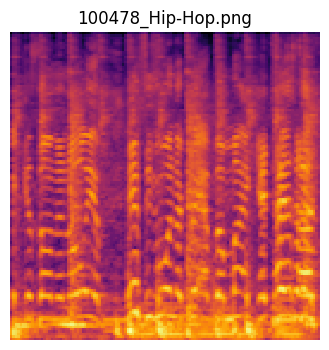

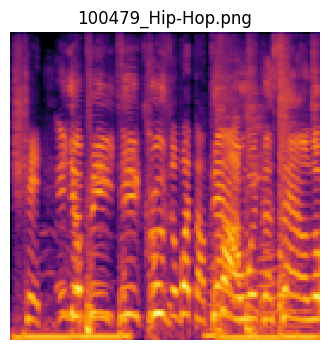

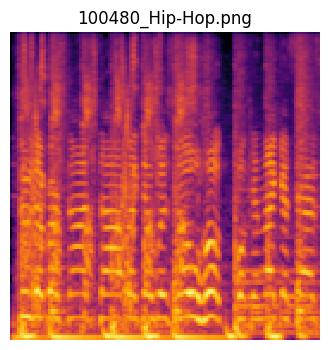

In [45]:
#first look to some spectrograms
img_files = sorted(os.listdir(OUTPUT_DIR))[:3]

for img_file in img_files:
    img_path = os.path.join(OUTPUT_DIR, img_file)
    img = mpimg.imread(img_path)

    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file)
    plt.show()



In [46]:
#Folder Organization
spectrogram_dir = "fma_spectrograms_clean"
dataset_dir = "dataset"
os.makedirs(dataset_dir, exist_ok=True)

tracks = pd.read_csv("fma_metadata/tracks.csv", index_col=0, header=[0,1])

copied = 0

for fname in os.listdir(spectrogram_dir):
    if not fname.lower().endswith(".png"):
        continue

    track_id_str = fname.split("_")[0]

    try:
        track_id = int(track_id_str)
    except:
        skipped += 1
        continue

    if track_id not in tracks.index:
        skipped += 1
        continue

    genre = tracks.loc[track_id, ('track','genre_top')]
    genre_dir = os.path.join(dataset_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)

    shutil.copy(os.path.join(spectrogram_dir, fname), os.path.join(genre_dir, fname))
    copied += 1





In [48]:
#TimeMask and FreqMask class creation for data augmentation
class TimeMask:
    def __init__(self, T=40):
        self.T = T

    def __call__(self, x):

        _, _, W = x.shape
        t = random.randint(0, self.T)
        t0 = random.randint(0, max(0, W - t))
        x[:, :, t0:t0+t] = 0
        return x

class FreqMask:
    def __init__(self, F=30):
        self.F = F

    def __call__(self, x):

        _, H, _ = x.shape
        f = random.randint(0, self.F)
        f0 = random.randint(0, max(0, H - f))
        x[:, f0:f0+f, :] = 0
        return x

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.RandomApply([TimeMask(T=30)], p=0.25),
    transforms.RandomApply([FreqMask(F=20)], p=0.25),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
dataset_dir = "/content/dataset"
raw_dataset = datasets.ImageFolder(dataset_dir)
num_classes = len(raw_dataset.classes)
full_indices = list(range(len(raw_dataset)))


In [49]:
#train/validation split
train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_idx, val_idx = torch.utils.data.random_split(full_indices, [train_size, val_size])

train_dataset_full = datasets.ImageFolder(dataset_dir, transform=train_transform)
val_dataset_full   = datasets.ImageFolder(dataset_dir, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset   = Subset(val_dataset_full, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)



In [50]:
#MIXUP
# data augmentation for improved generalization

def mixup(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx], lam)


def mixup_loss(criterion, pred, targets):
    y1, y2, lam = targets
    return lam * criterion(pred, y1) + (1 - lam) * criterion(pred, y2)

In [51]:
# MODEL INITIALIZATION
# MODEL USED:VIT-B/16
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model = model.cuda()



In [52]:
# INITIALIZATION OPTIMIMIZER / LOSS / SCHEDULER/ SCALER

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW([
    {"params": model.heads.parameters(), "lr": 1e-3},
    {"params": [p for n,p in model.named_parameters() if "heads" not in n], "lr": 5e-5},
], weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)
scaler = GradScaler()


In [53]:

# METRICHS + FREEZE UTILITIES
def compute_metrics(y_true, y_pred):
    acc = (y_true == y_pred).mean() * 100
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return acc, prec, rec, f1

def unfreeze_all():
    for p in model.parameters():
        p.requires_grad = True
def freeze_backbone():
    for name, param in model.named_parameters():
        if not name.startswith("heads"):
            param.requires_grad = False
device = torch.device("cuda" )



In [54]:
# TRAIN EPOCH

def train_epoch(loader):
    model.train()
    total_loss = 0.0

    for images, labels in loader:
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

# VALIDATION
def validate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            with autocast("cuda"):
                preds = model(images)
                loss = criterion(preds, labels)
            total_loss += loss.item()
            all_preds.append(preds.argmax(1).cpu())
            all_labels.append(labels.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    acc, prec, rec, f1 = compute_metrics(y_true, y_pred)
    return total_loss / len(loader), acc, prec, rec, f1

In [55]:
# TRAINING LOOP
# WE START WITH A WARMUP PHASE TRAINING ONLY THE HEAD FOR 4 EPOCHS AND THEN A SECOND PHASE WITH FULL FINETUNING

best_val_loss = float("inf")
best_model_state = None
patience =
patience_counter = 0
train_losses = []
val_losses = []

# ---- WARMUP (HEAD ONLY)
freeze_backbone()
print("\n--- WARMUP ---")
for epoch in range(4):
    tl = train_epoch(train_loader)
    vl, acc, p, r, f1 = validate(val_loader)
    print(f"Ep {epoch+1} | Train {tl:.4f} | Val {vl:.4f} | "
          f"Acc {acc:.2f}% P {p:.3f} R {r:.3f} F1 {f1:.3f}")

# ---- FULL FINETUNING
unfreeze_all()
optimizer.param_groups[0]["lr"] = 1e-5
print("\n--- FULL FINETUNING ---")

for epoch in range(8):
    tl = train_epoch(train_loader)
    vl, acc, p, r, f1 = validate(val_loader)
    scheduler.step()

    train_losses.append(tl)
    val_losses.append(vl)

    print(f"Ep {epoch+1:02d} | Train {tl:.4f} | Val {vl:.4f} | "
          f"Acc {acc:.2f}% P {p:.3f} R {r:.3f} F1 {f1:.3f}")

    if vl < best_val_loss:
        best_val_loss = vl
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early Stopping Triggered")

            break
model.load_state_dict(best_model_state)
print(f"\nBest Validation Loss: {best_val_loss:.4f}")


--- WARMUP ---
Ep 1 | Train 1.7953 | Val 1.6905 | Acc 43.62% P 0.442 R 0.437 F1 0.418
Ep 2 | Train 1.6796 | Val 1.6616 | Acc 44.81% P 0.460 R 0.456 F1 0.420
Ep 3 | Train 1.6362 | Val 1.6037 | Acc 48.38% P 0.478 R 0.488 F1 0.465
Ep 4 | Train 1.6158 | Val 1.6038 | Acc 48.00% P 0.520 R 0.479 F1 0.487

--- FULL FINETUNING ---
Ep 01 | Train 1.6335 | Val 1.5352 | Acc 51.88% P 0.570 R 0.518 F1 0.516
Ep 02 | Train 1.4868 | Val 1.4435 | Acc 55.06% P 0.576 R 0.548 F1 0.549
Ep 03 | Train 1.4121 | Val 1.4079 | Acc 57.19% P 0.570 R 0.571 F1 0.552
Ep 04 | Train 1.3236 | Val 1.4534 | Acc 56.06% P 0.595 R 0.561 F1 0.561
Ep 05 | Train 1.2375 | Val 1.4233 | Acc 58.50% P 0.588 R 0.589 F1 0.584
Ep 06 | Train 1.1419 | Val 1.4805 | Acc 57.25% P 0.569 R 0.571 F1 0.563
Ep 07 | Train 1.0271 | Val 1.4894 | Acc 58.94% P 0.592 R 0.587 F1 0.583
Early Stopping Triggered

Best Validation Loss: 1.4079


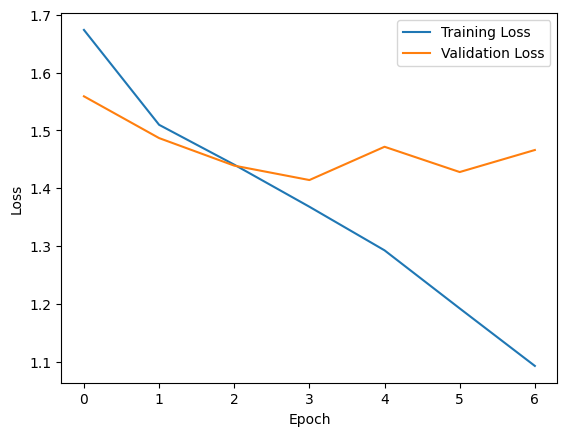

In [39]:

#TRAINING-ACCURACY LOSS PLOT
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
